### Implemention a VAE to generate new images of handwritten digits.

#### Import the relevant packages and define the device

In [1]:
from torch_snippets import *
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Define the transformation required for the images 

In [2]:
images_tranform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Lambda(lambda x: x.to(device))])

#### Define the training and validation dataset

In [3]:
datafolder = 'dataset/'
train_dataset = MNIST(datafolder, train=True, download=True, transform=images_tranform)
valid_dataset = MNIST(datafolder, train=False, download=True, transform=images_tranform)

#### Define the dataloader

In [4]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#### Define the network architecture 

In [5]:
class VAE(nn.Module):
    def __init__(self,x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        # encoder part
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
    
    def encode(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    
    def sampling(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.sampling(mu, logvar)
        return self.decoder(z), mu, logvar


### Define the training function

In [6]:
def train_batch(data, model,  optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    recon_batch, mu, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mu, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mu.mean()

#### Define the validation function

In [7]:
@torch.no_grad()
def valid_batch(data, model, loss_fucntion):
    model.eval()
    recon, mu, logvar = model(data)
    loss, mse, kld = loss_fucntion(recon, data, mu, logvar)
    return loss, mse, kld , logvar.mean(), mu.mean()

#### Define loss function

In [8]:
def loss_fcuntion (recon_x, x , mu, logvar):
    RECON = F.mse_loss(recon_x, x.view(-1, 784) , reduction='sum')
    KLD = -0.5 * torch.sum(1+ logvar - mu.pow(2) - logvar.exp()) 
    return RECON + KLD , RECON , KLD

#### Define the model and the optimizer

In [9]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256,z_dim=50).to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

#### Train the models over epochs

EPOCH: 1.000  val_mean: -0.011  val_loss: 2405.737  train_mean: -0.002  val_kld: 449.916  train_kld: 2673.311  val_log_var: -0.285  train_loss: 2923.520  val_recon: 1955.821  train_recon: 250.208  train_log_var: -0.150  (9.91s - 237.96s remaining)
EPOCH: 2.000  val_mean: -0.009  val_loss: 2114.331  train_mean: 0.000  val_kld: 552.878  train_kld: 1751.105  val_log_var: -0.340  train_loss: 2233.430  val_recon: 1561.453  train_recon: 482.324  train_log_var: -0.293  (19.99s - 229.91s remaining)
EPOCH: 2.387  train_loss: 2125.195  train_kld: 1591.366  train_recon: 533.828  train_log_var: -0.329  train_mean: 0.012  (23.40s - 221.66s remaining))

KeyboardInterrupt: 

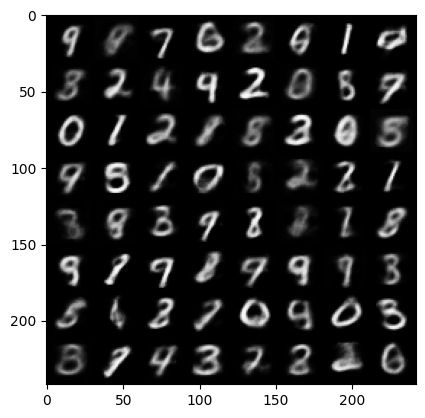

In [10]:
num_epoch = 25
log = Report(num_epoch)

for epoch in range(num_epoch):
    N = len(train_dataloader)
    for batch_idx, (data, _) in enumerate(train_dataloader):
        loss, kld, recon, log_var, mean = train_batch(data, vae,  optimizer,loss_fcuntion)

        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon,train_log_var=log_var, train_mean=mean, end='\r')

    N = len(valid_dataloader)
    for batch_idx, (data, _) in enumerate(valid_dataloader):
        loss, recon, kld,log_var,mean = valid_batch(data, vae, loss_fcuntion)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
    
    log.report_avgs(epoch+1)

    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        plt.imshow(images.cpu().detach().numpy(), cmap='gray')


#### Visualize the training and validation loss

100%|██████████| 121/121 [00:00<00:00, 298.32it/s]


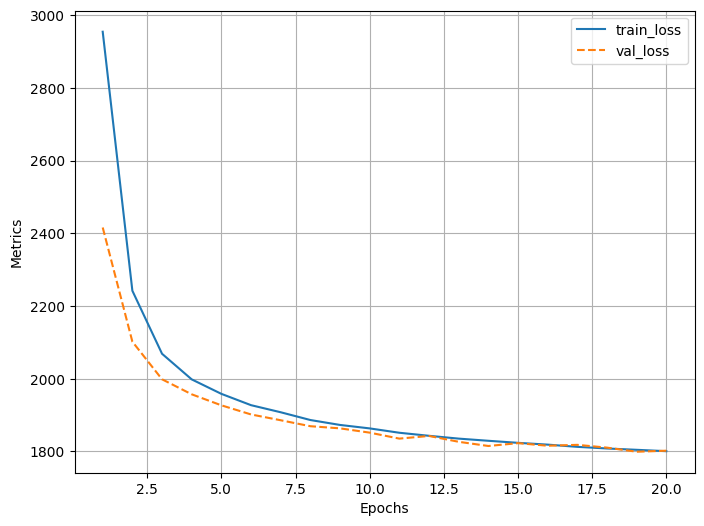

In [ ]:
log.plot_epochs(['train_loss','val_loss'])